In [11]:
import requests
import json
import ipywidgets as widgets
import base64
import os
from dotenv import load_dotenv
import concurrent.futures

load_dotenv()
bria_api_token = os.environ.get("BRIA_API_KEY", "Not Found")
bria_api_url = "https://engine.prod.bria-api.com/v1/background/remove"

In [16]:
image_urls = [

    # These work
    "https://plus.unsplash.com/premium_photo-1676490314509-3b7a26467f08",
    "https://plus.unsplash.com/premium_vector-1740179881618-6f77493f2129",
    "https://plus.unsplash.com/premium_vector-1740089174065-87d536a05406",
    "https://plus.unsplash.com/premium_photo-1738854510280-6ea693334b8b",
    "https://plus.unsplash.com/premium_photo-1664457233863-70b06c589907",
    "https://plus.unsplash.com/premium_photo-1726845105874-29f95e03fb88",
    "https://plus.unsplash.com/premium_photo-1724255994628-dceb76a829e8",
    "https://plus.unsplash.com/premium_photo-1738772658357-2342bcd15858",
    "https://plus.unsplash.com/premium_photo-1673530702342-9487932e6da9",
    "https://plus.unsplash.com/premium_photo-1733317315148-6e35f7486403",
    "https://plus.unsplash.com/premium_photo-1739400653558-7c44a6922ba3",
    "https://plus.unsplash.com/premium_photo-1678371209911-440cb914e9cb",

    # These don't make too much sense for a BG removal
    "https://plus.unsplash.com/premium_photo-1740354612104-c1684b396782",
    "https://plus.unsplash.com/premium_photo-1739413060032-d01e0d2f9a3c",
    "https://plus.unsplash.com/premium_photo-1739389293755-feba9314a482",
    "https://plus.unsplash.com/premium_photo-1692026998357-598980d9c22c",
    "https://plus.unsplash.com/premium_photo-1734543932100-96cf06f153c3",
]


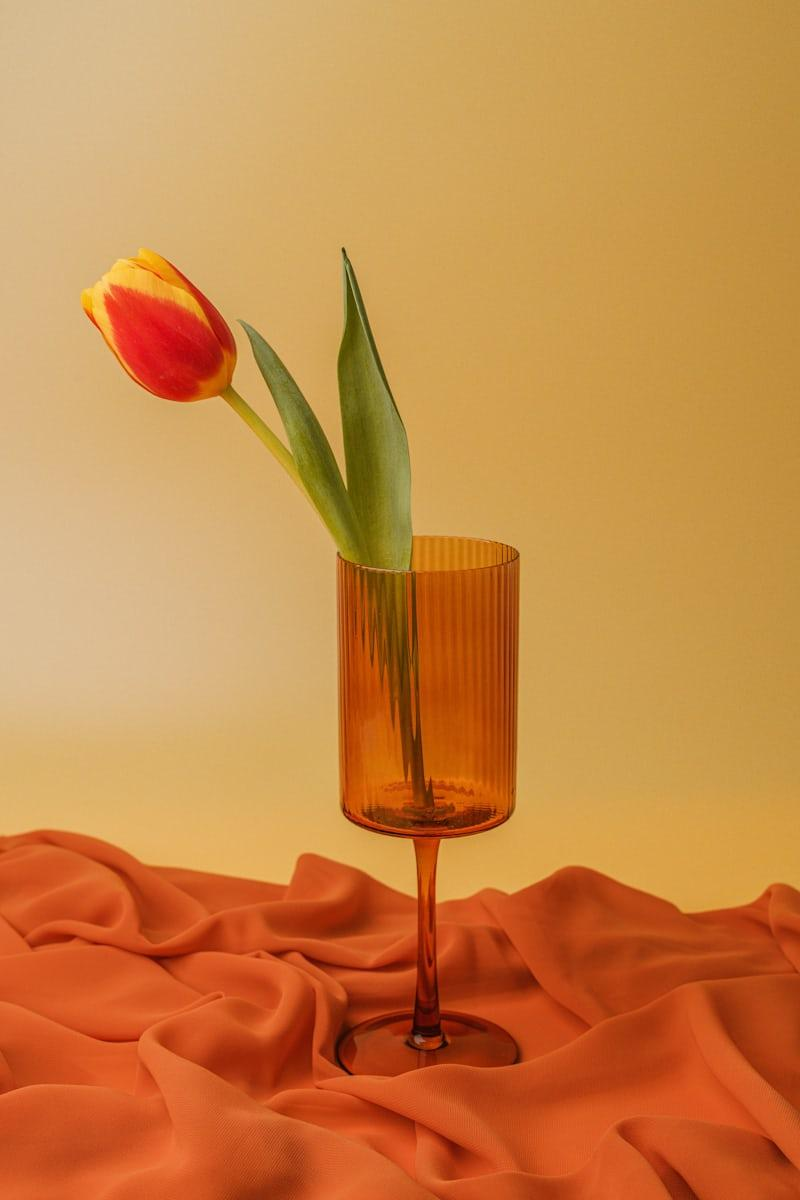
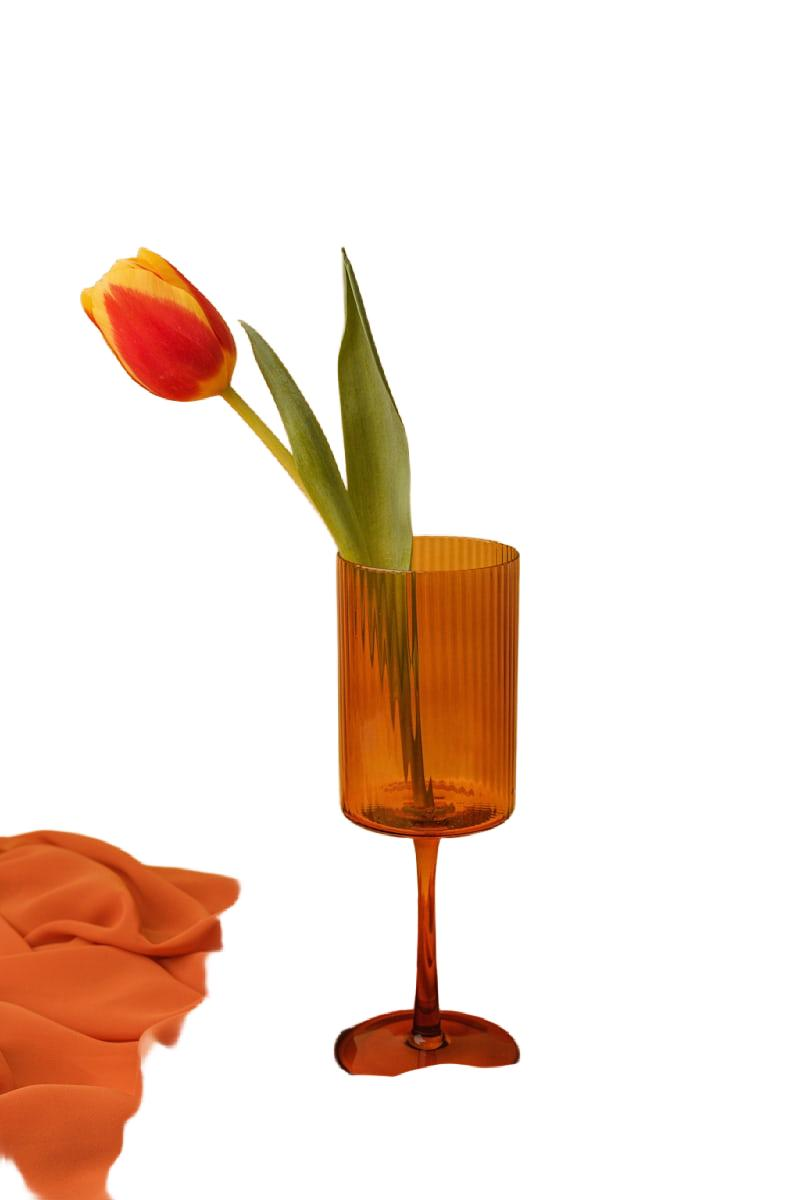


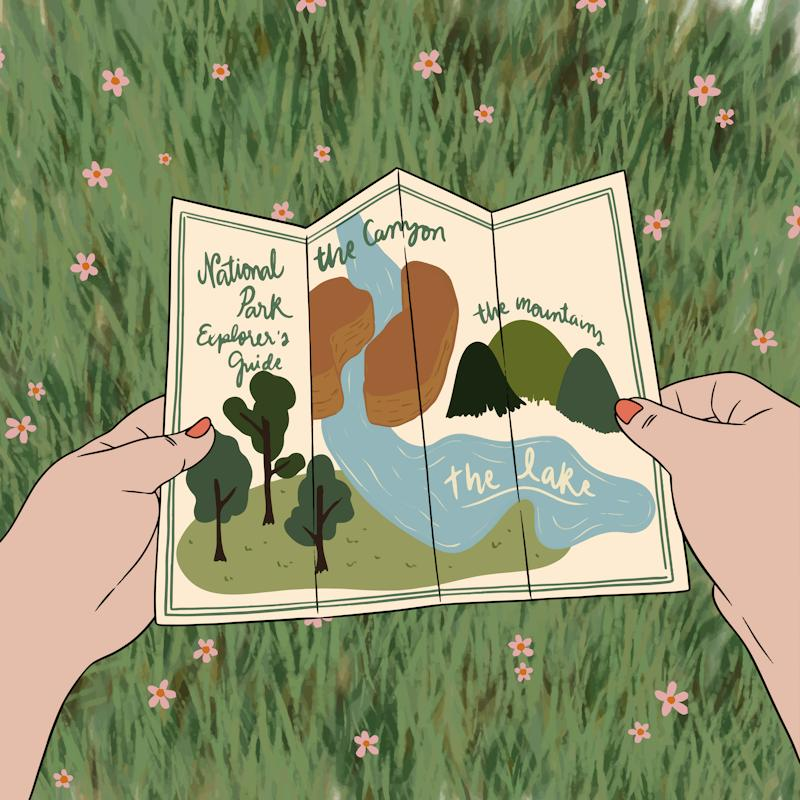
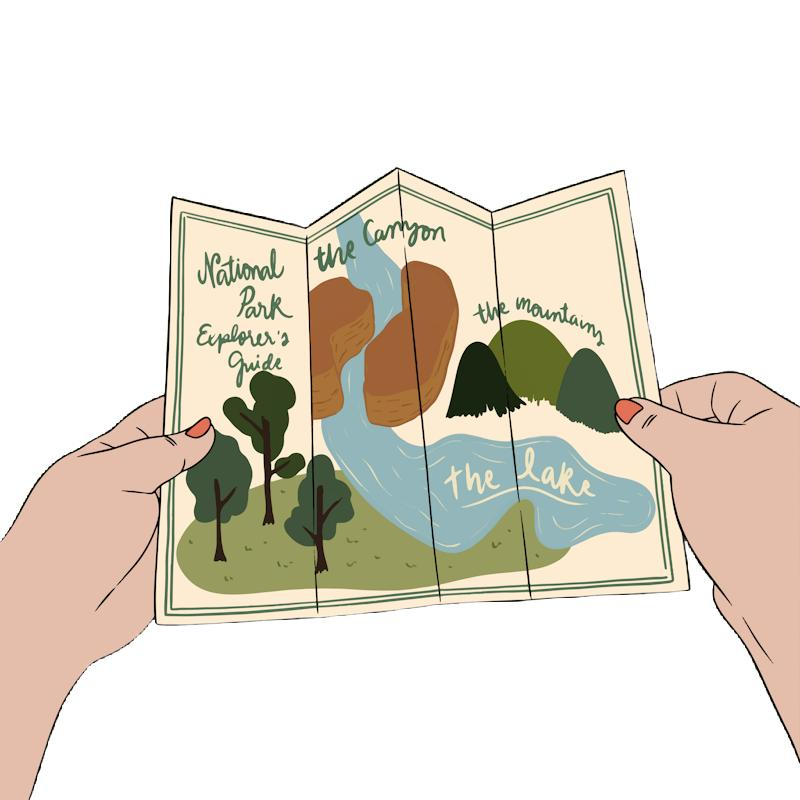


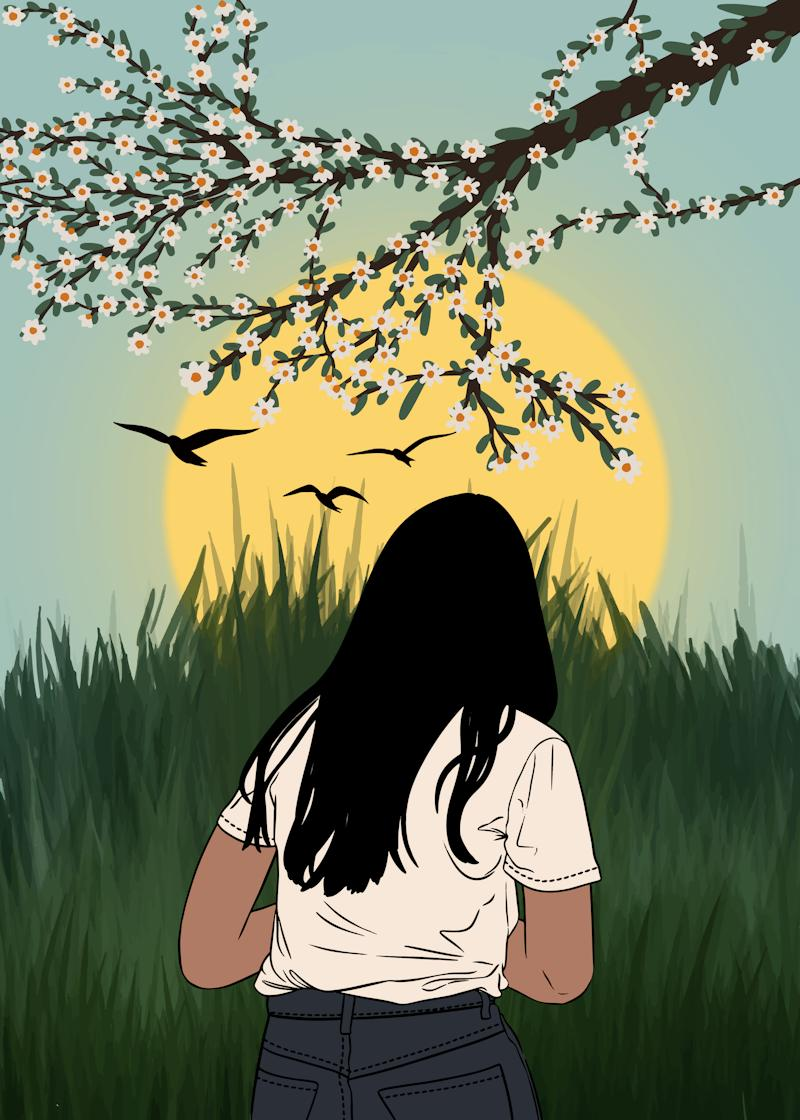
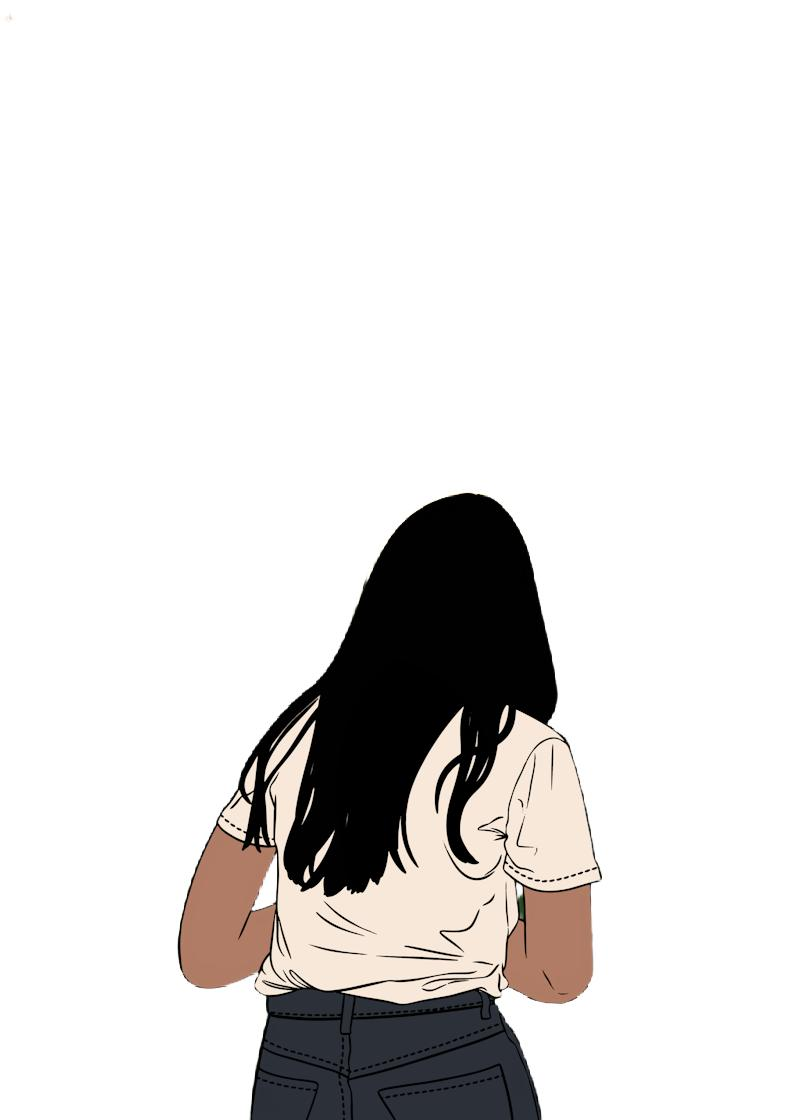


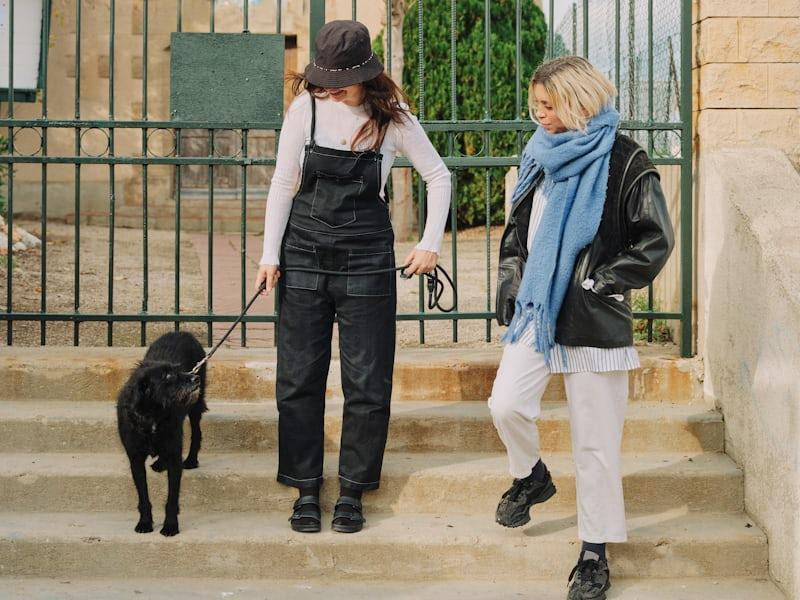
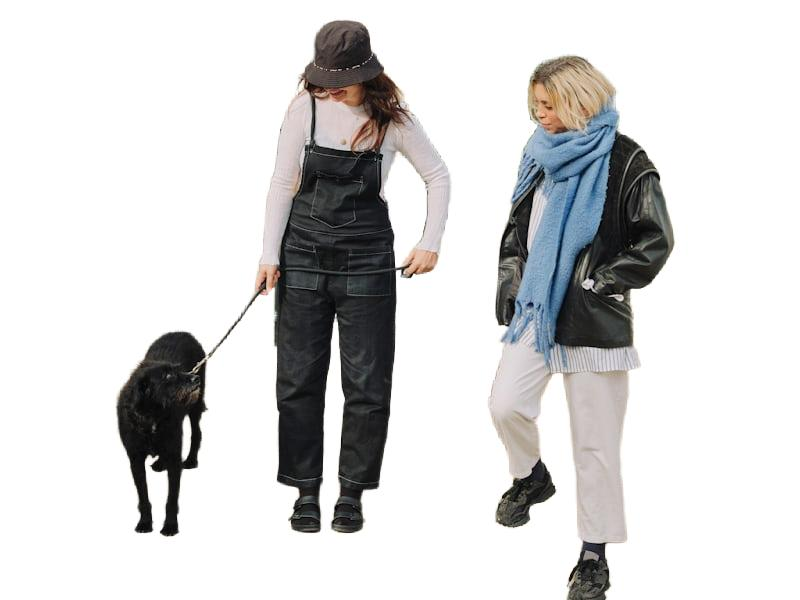


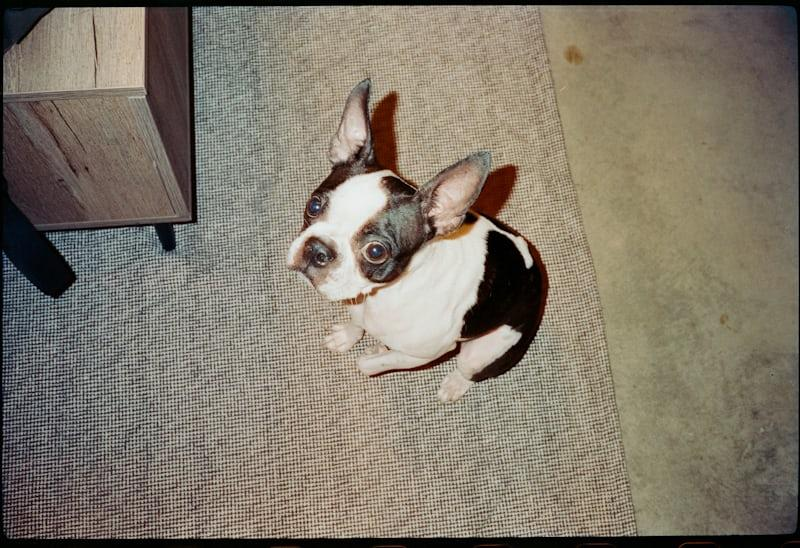
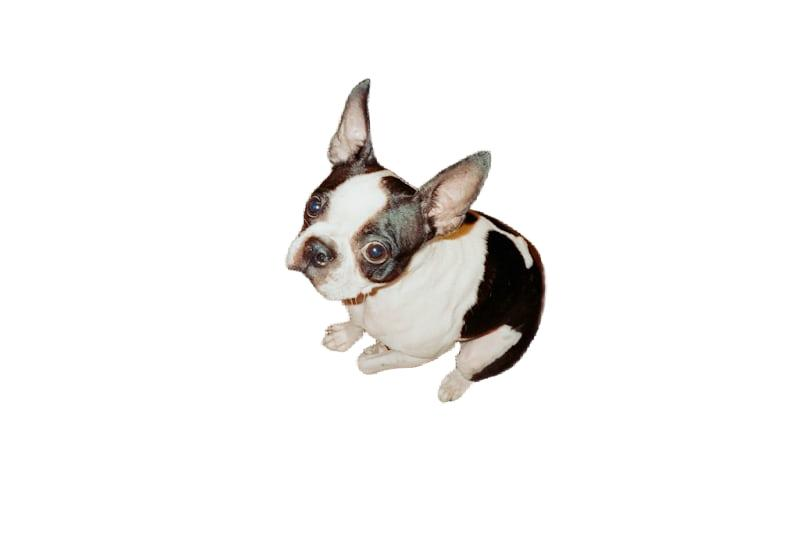


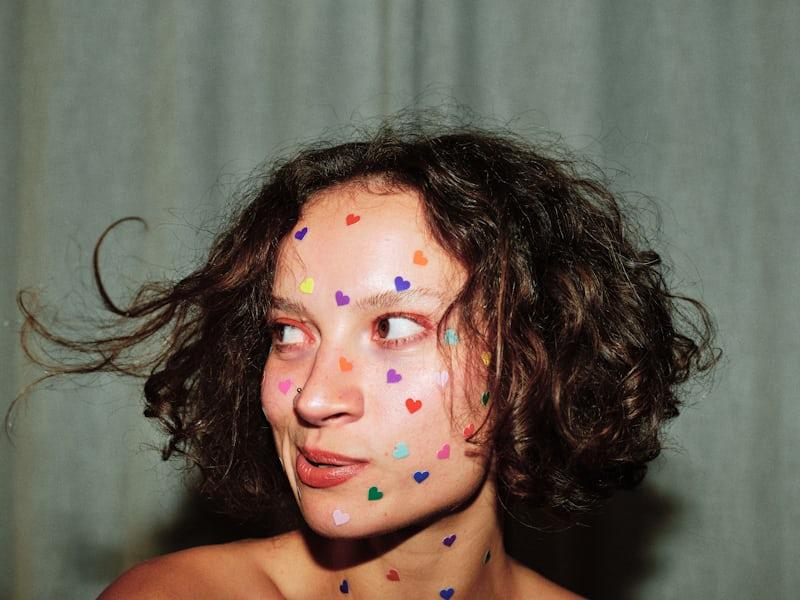
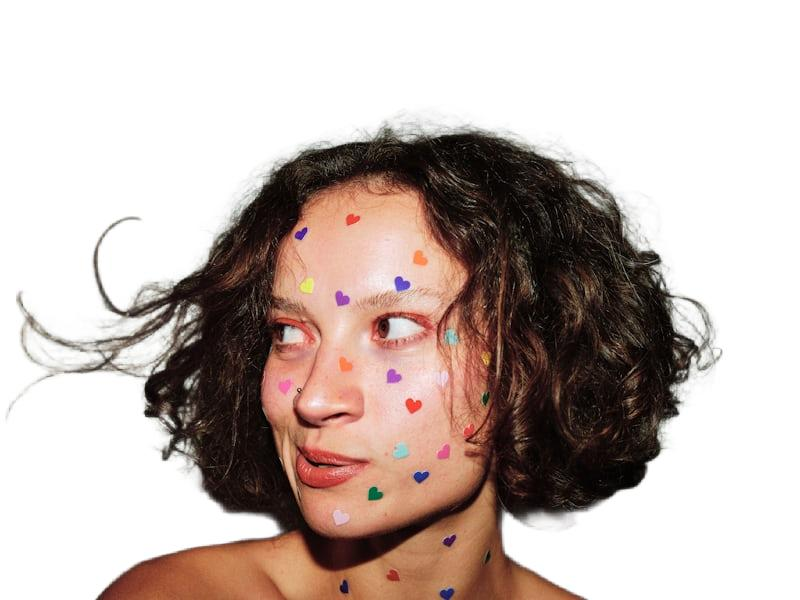


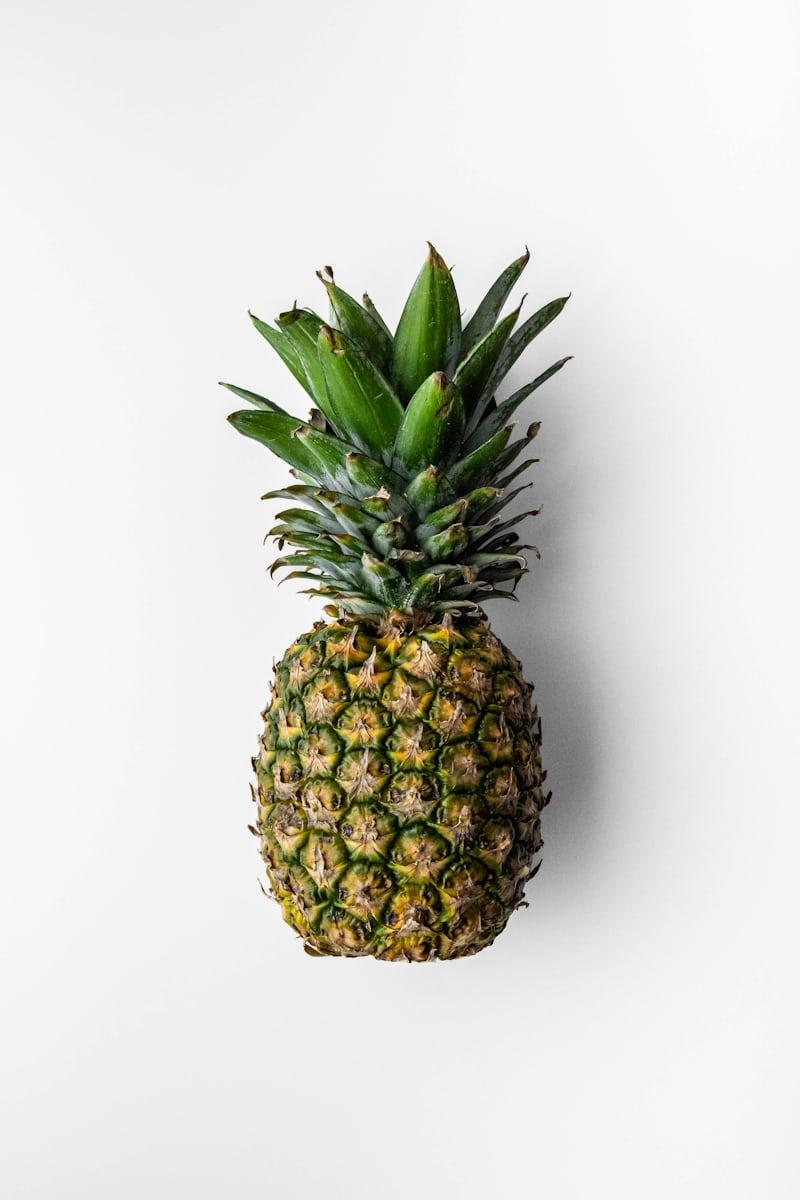
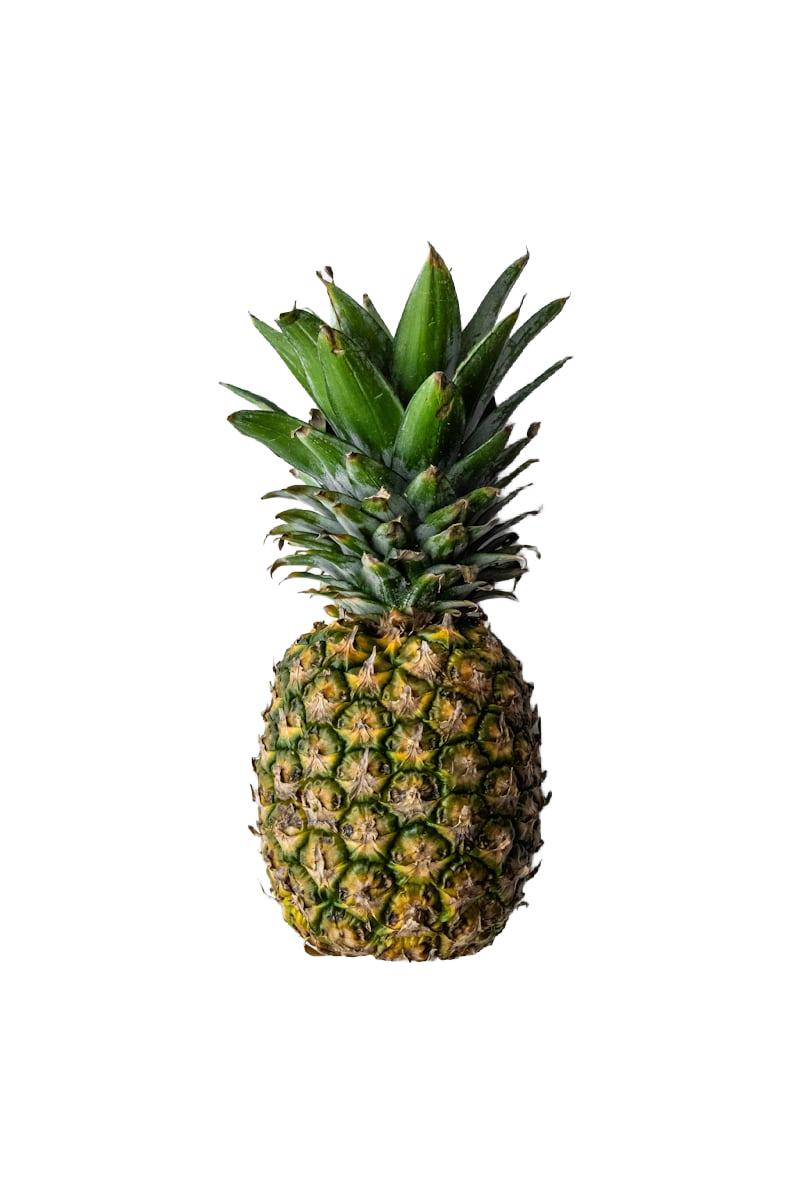


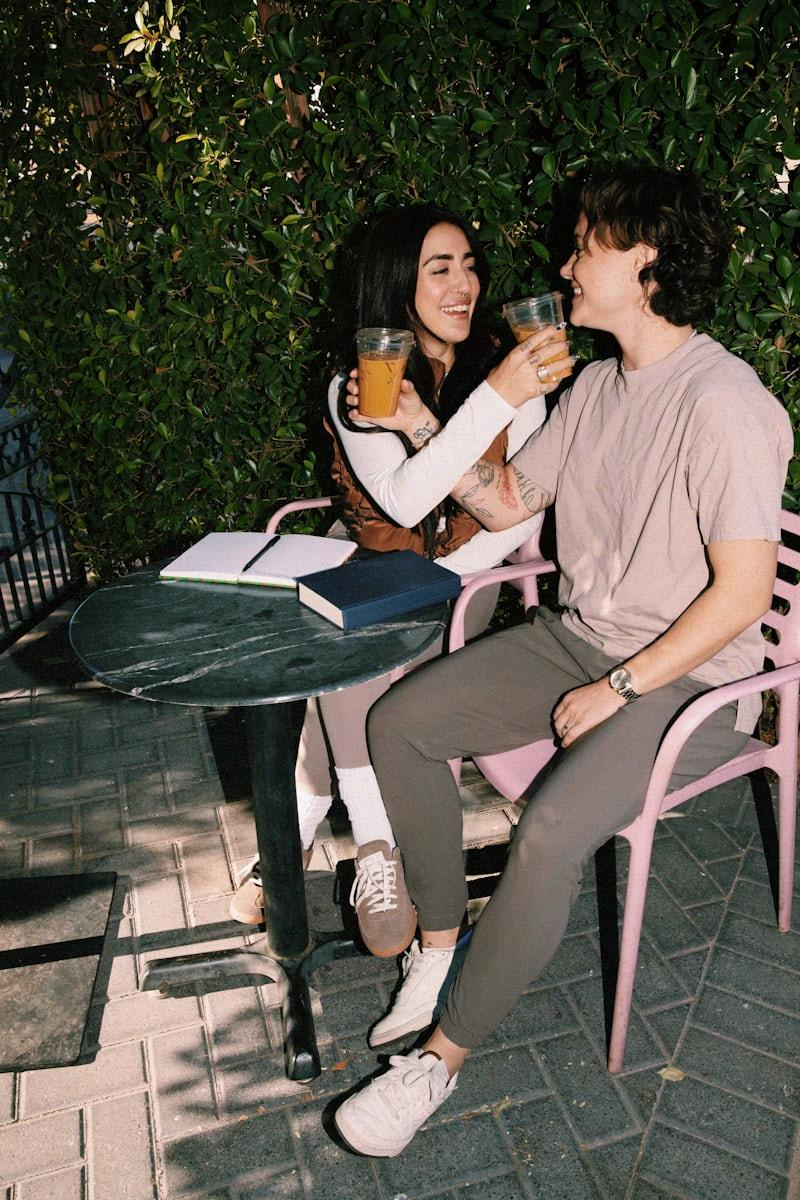
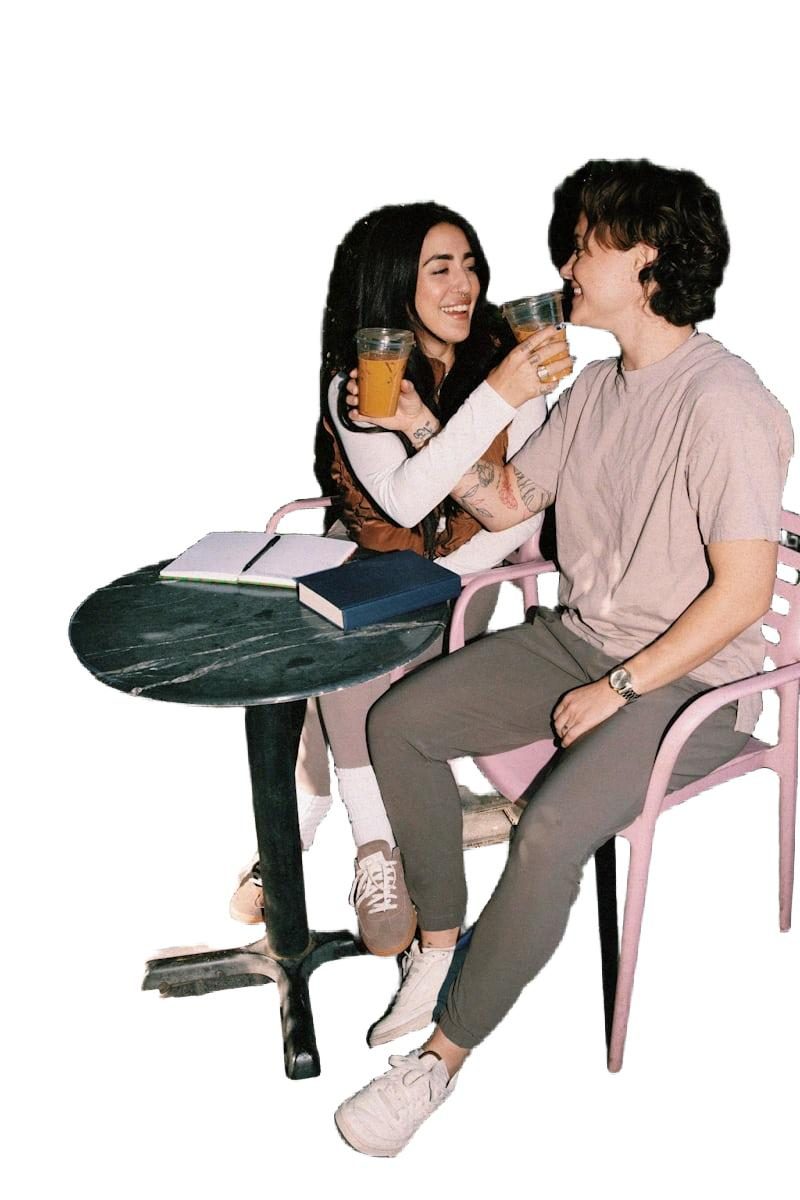


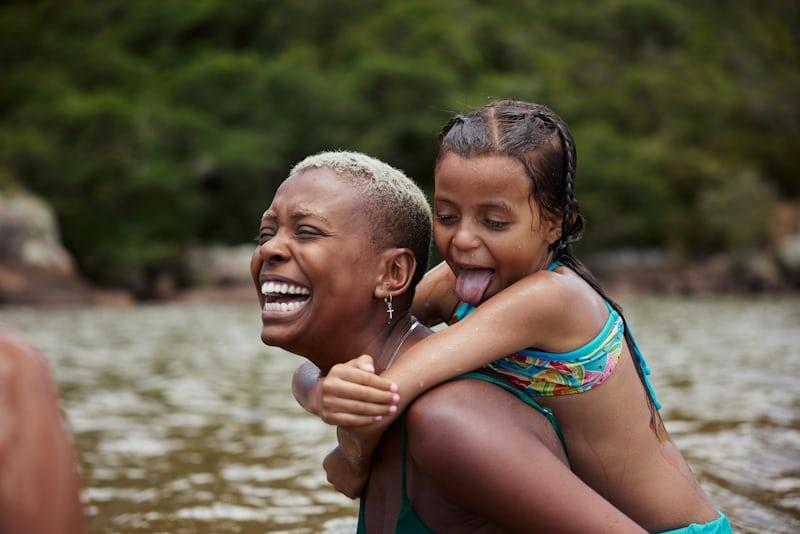
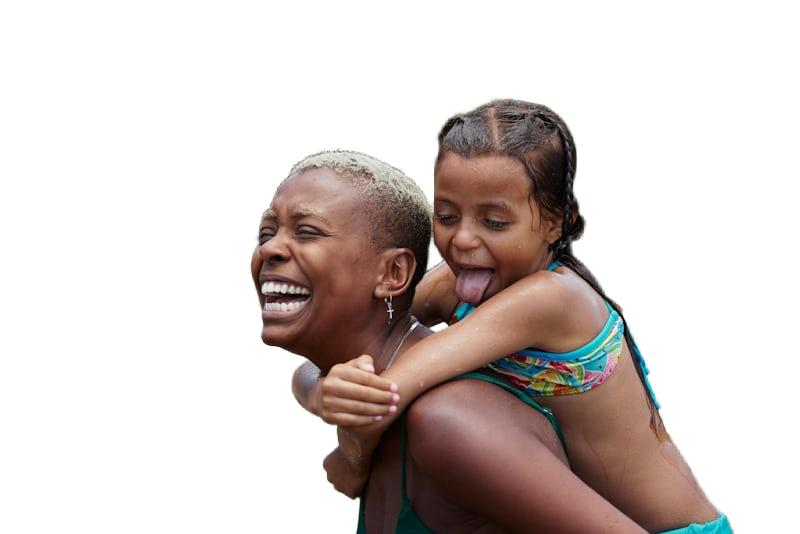


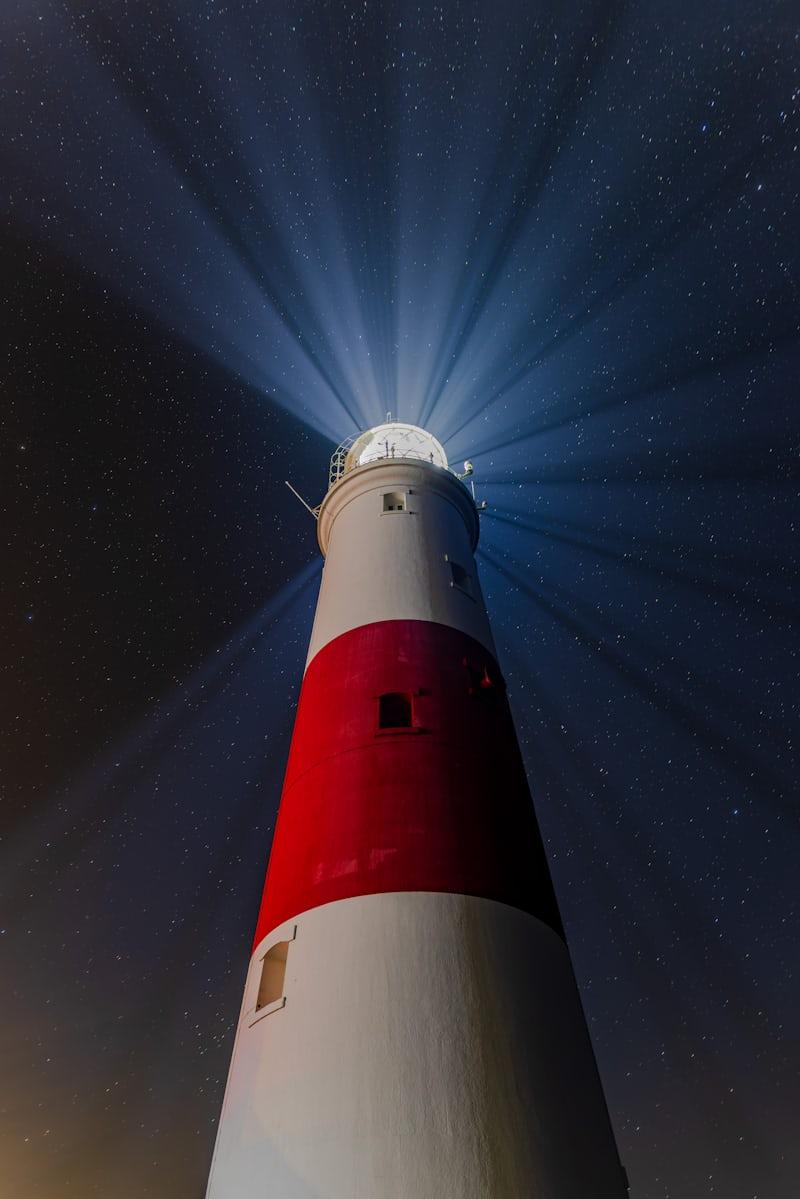
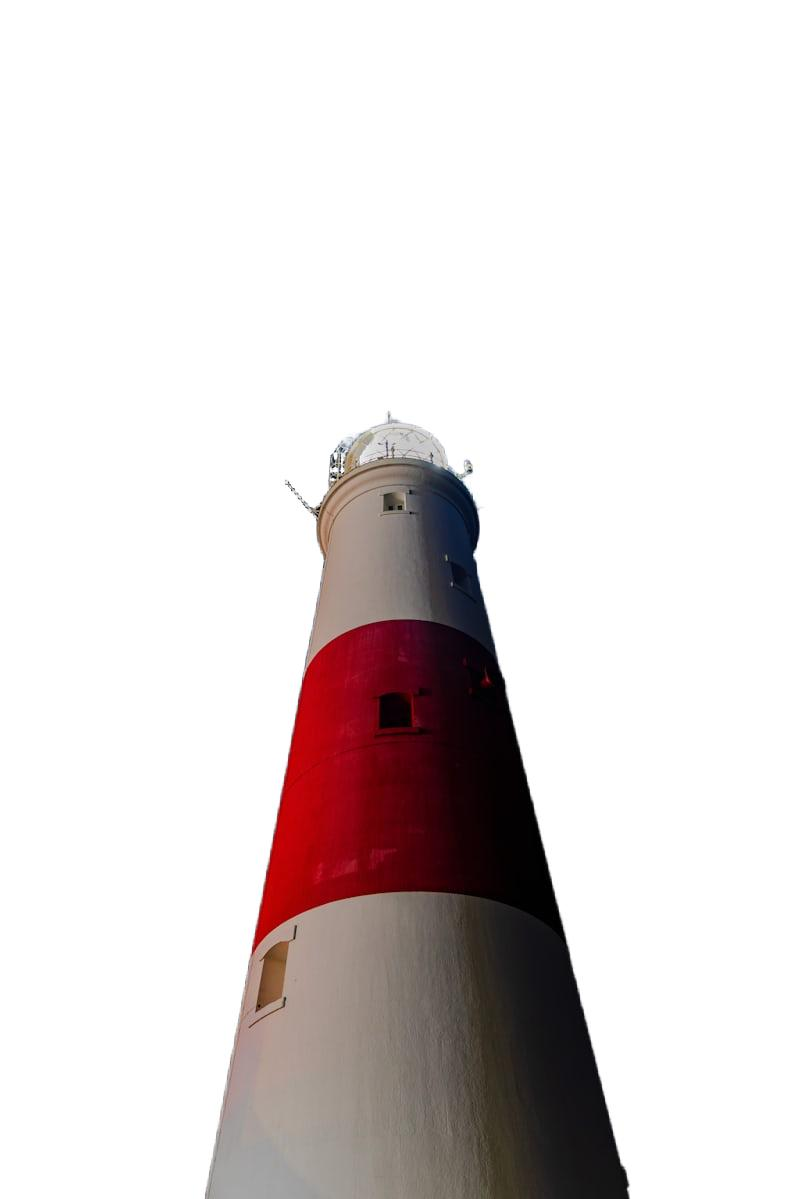


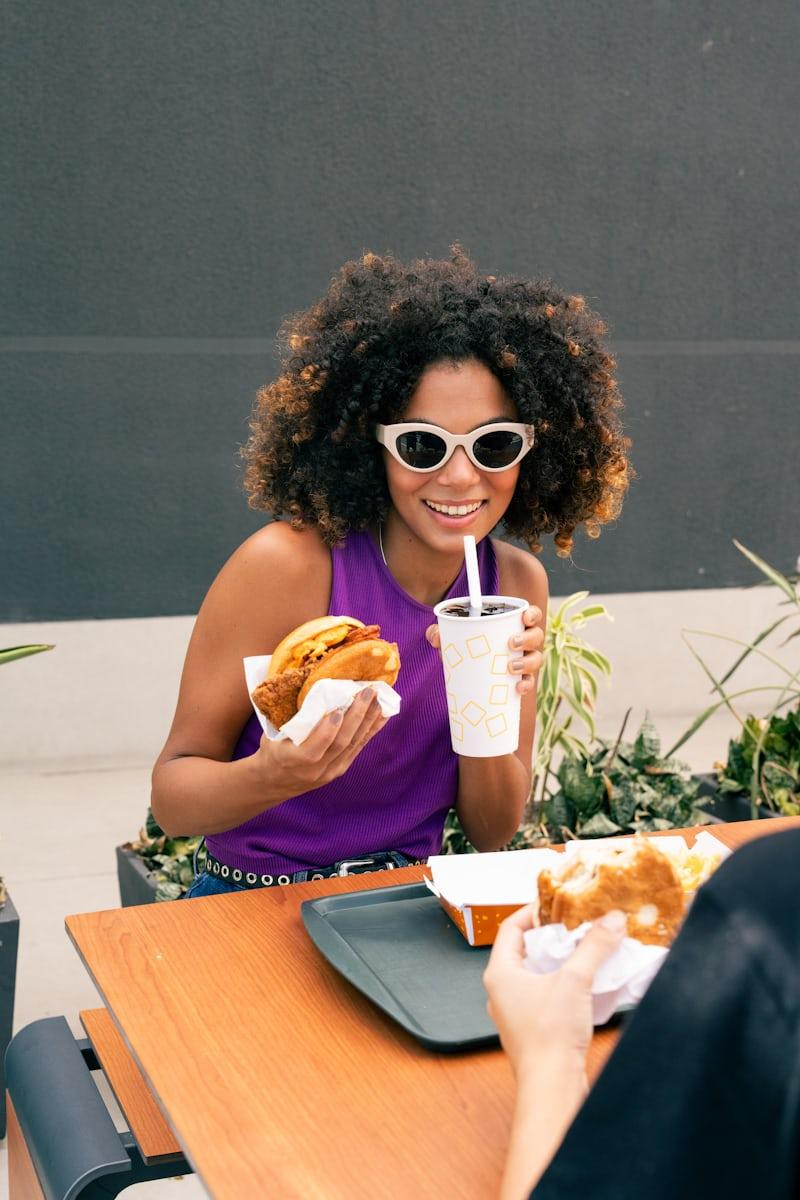
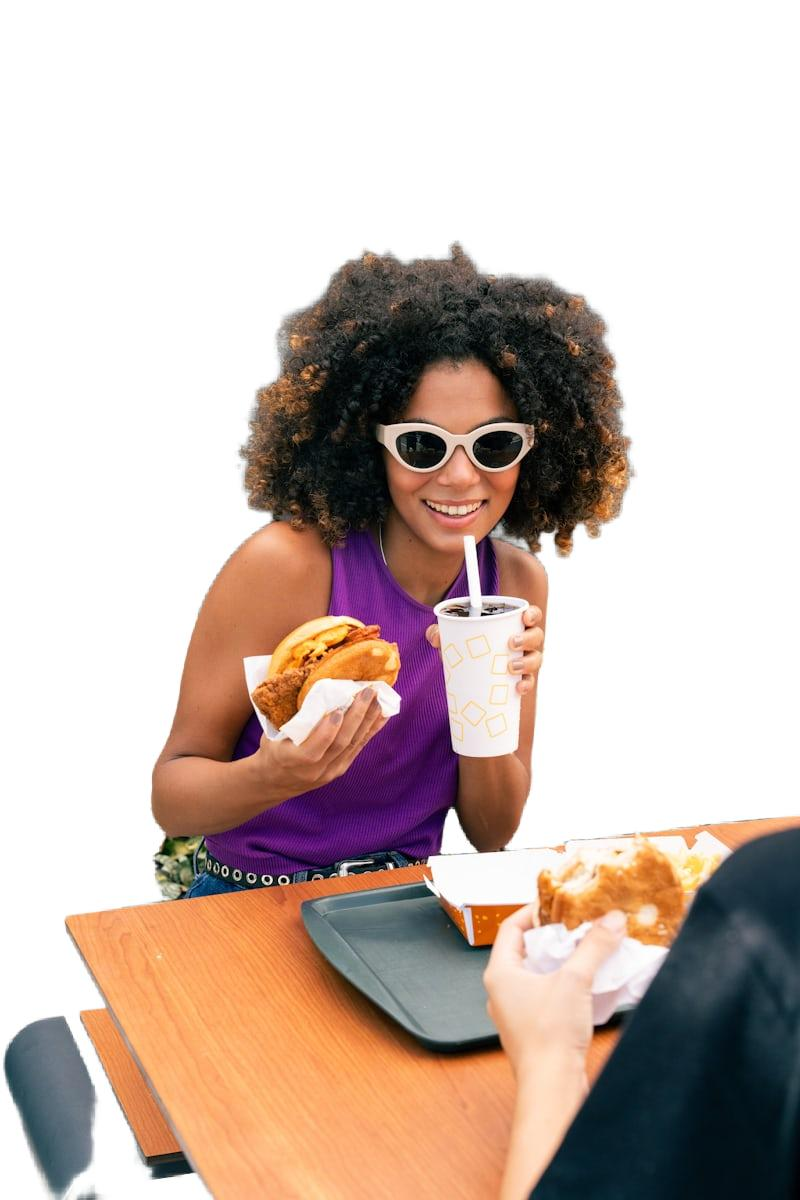


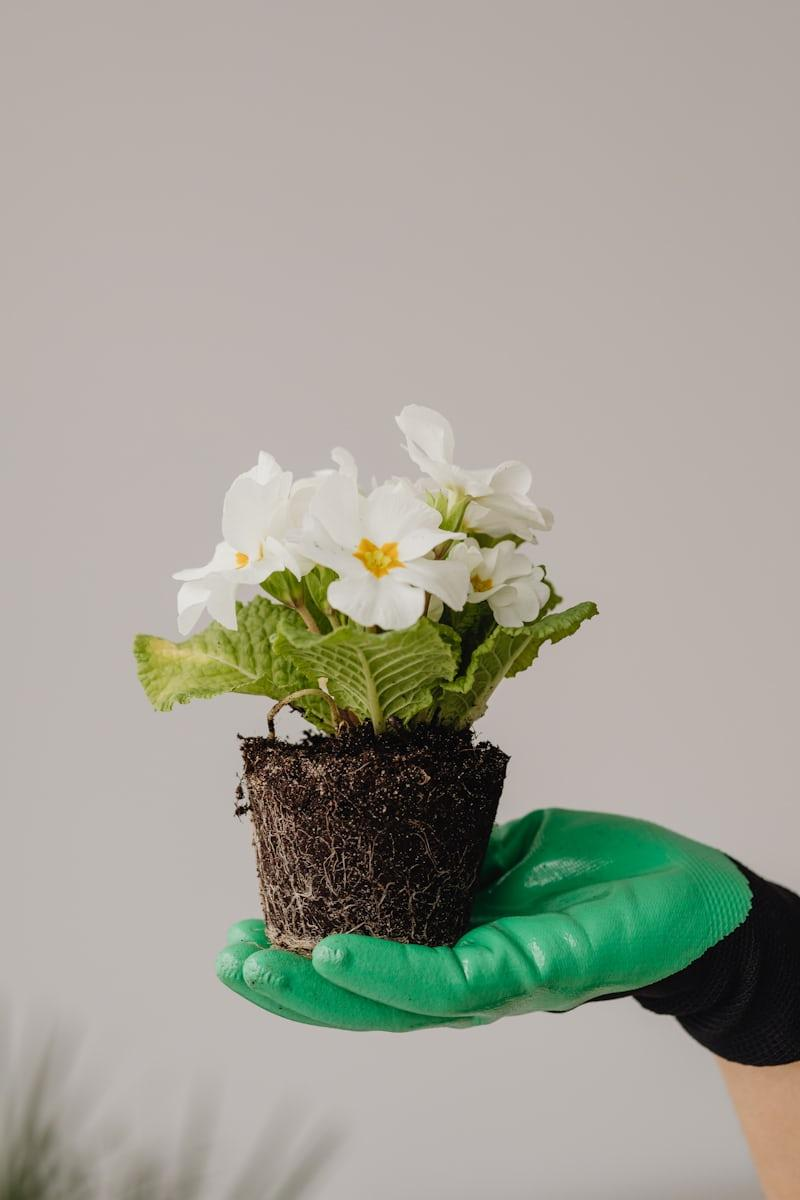
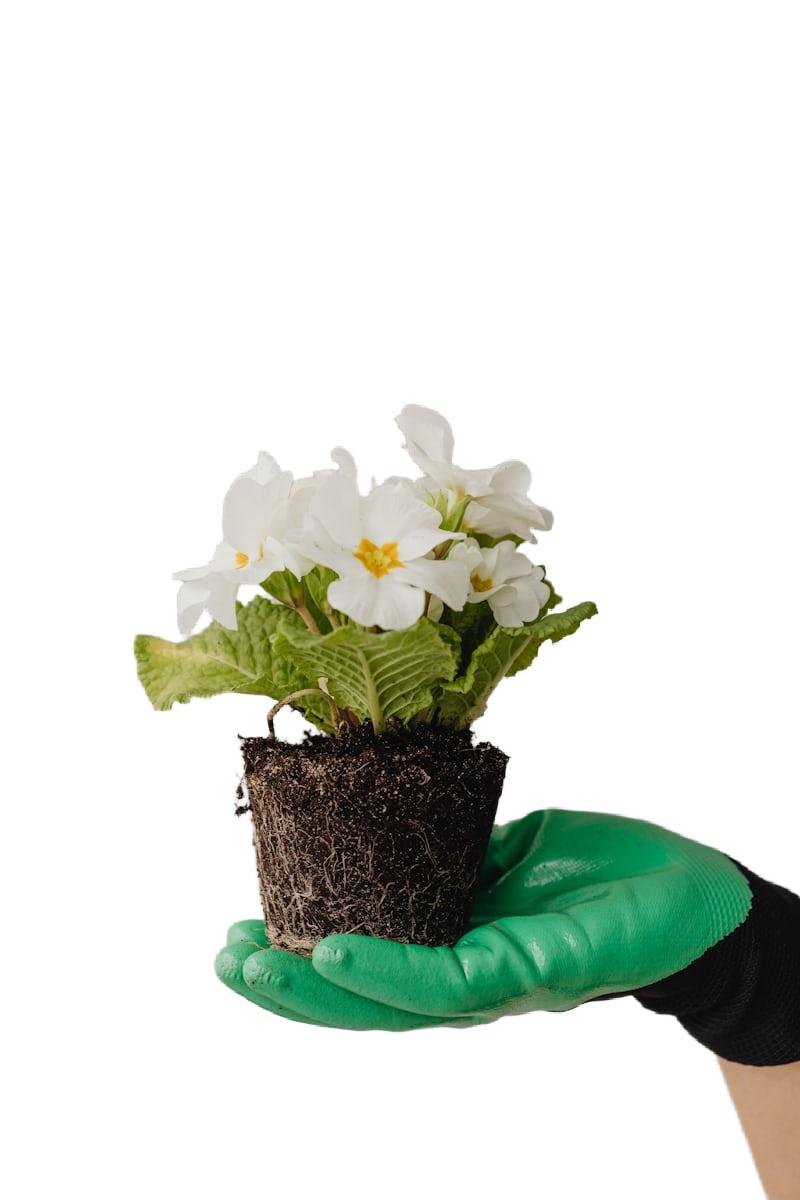


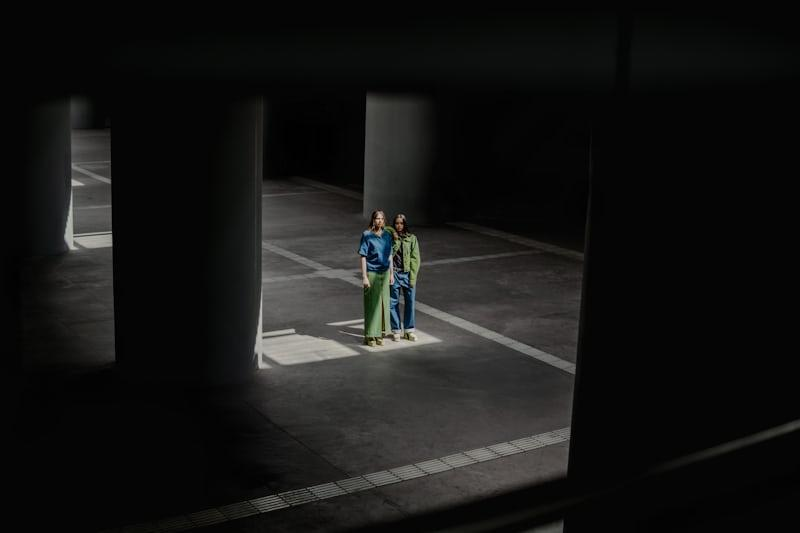
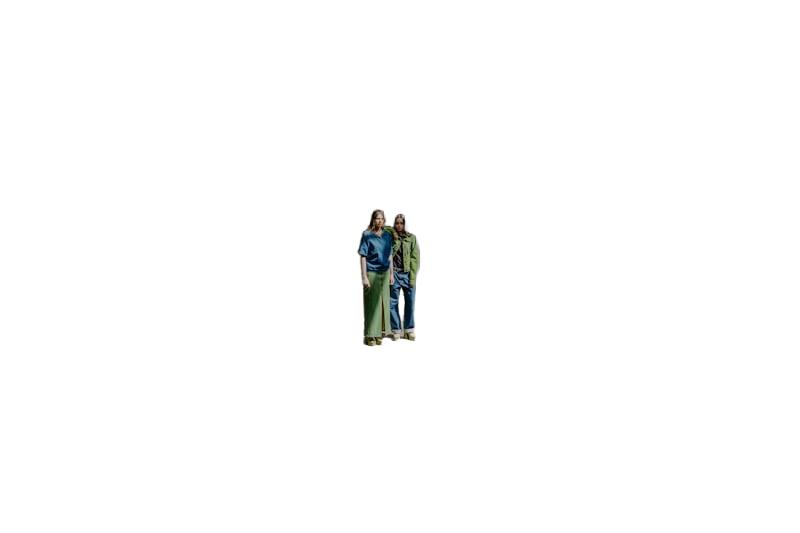


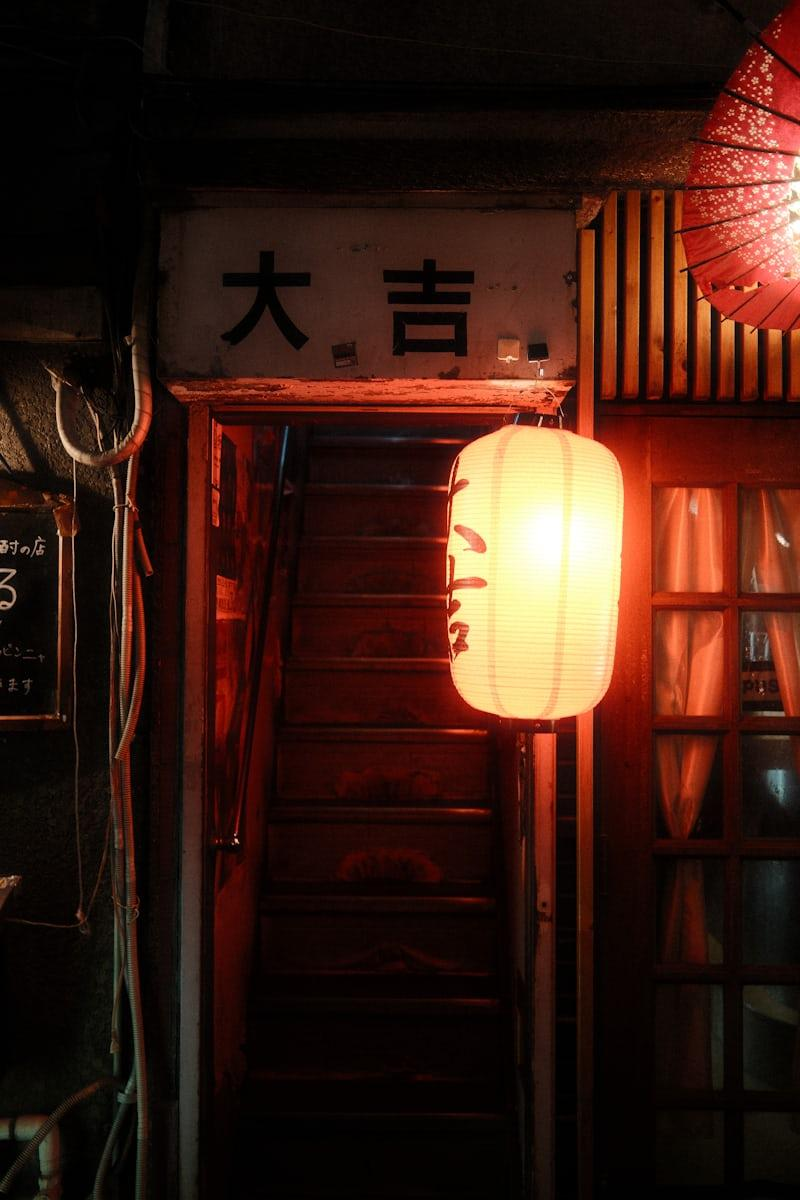
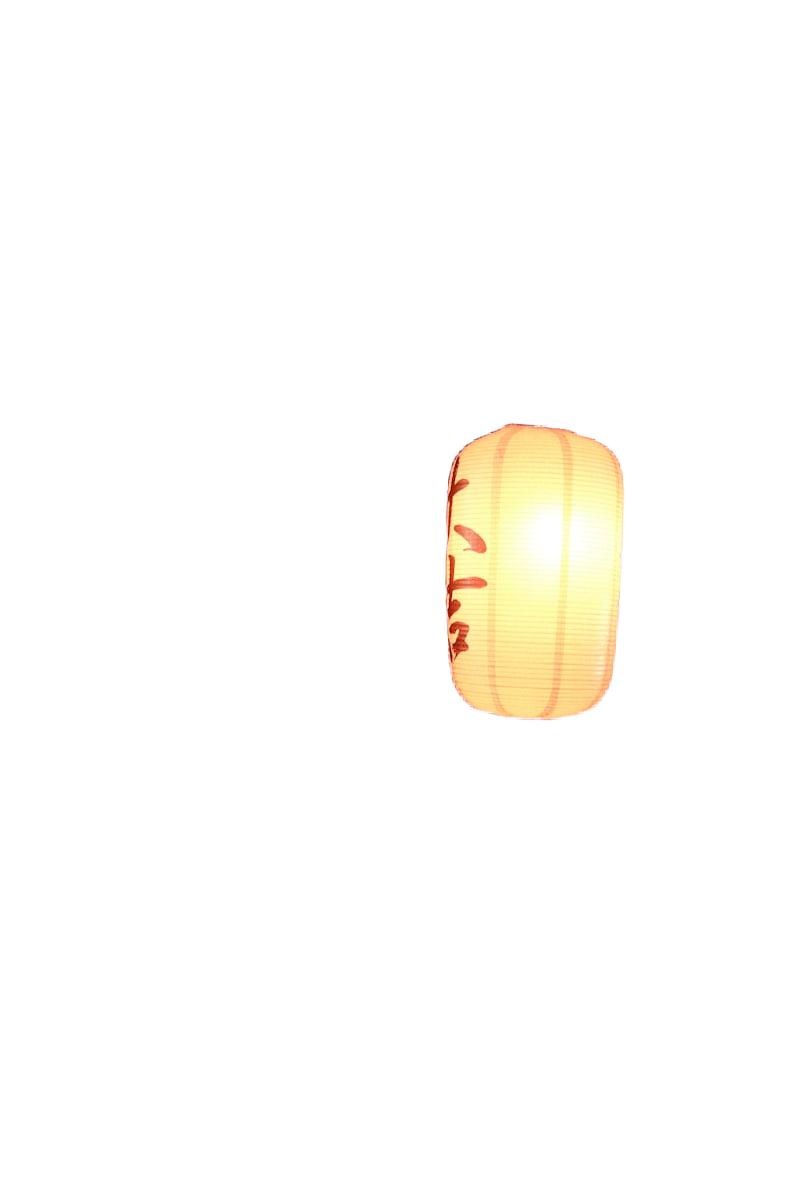


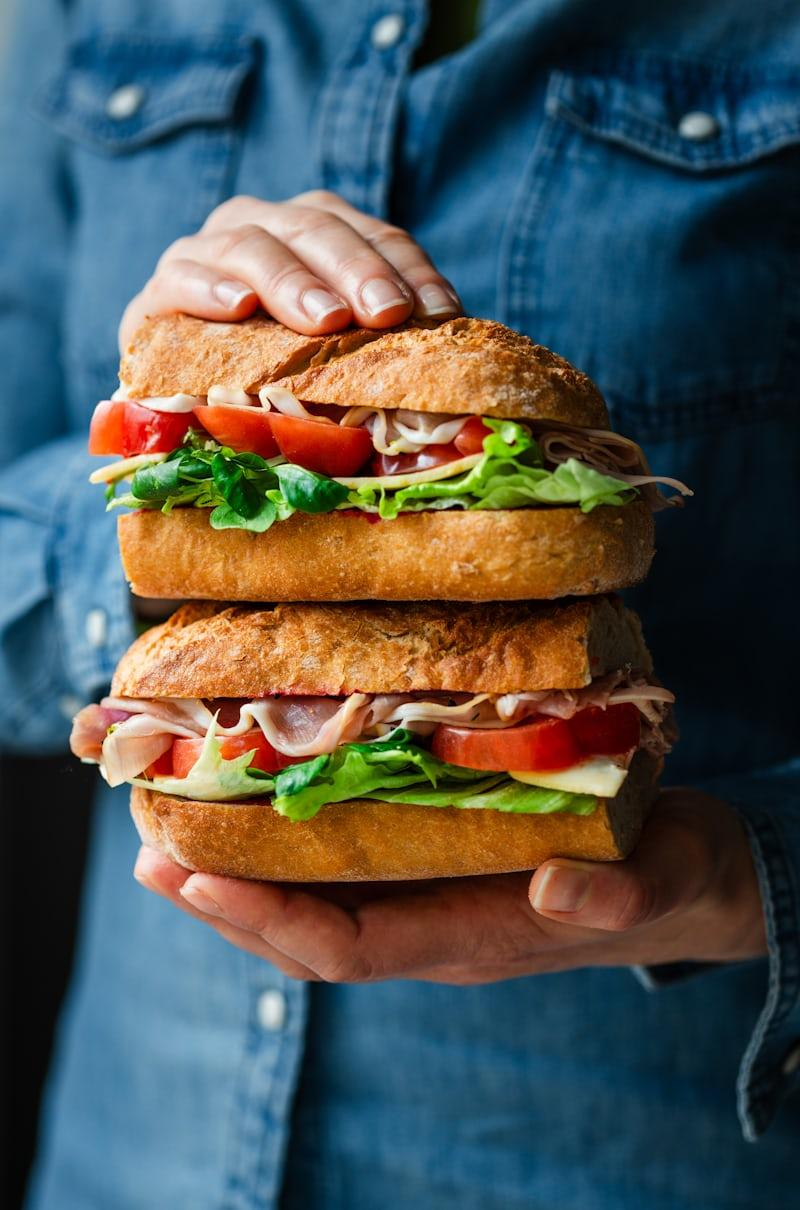
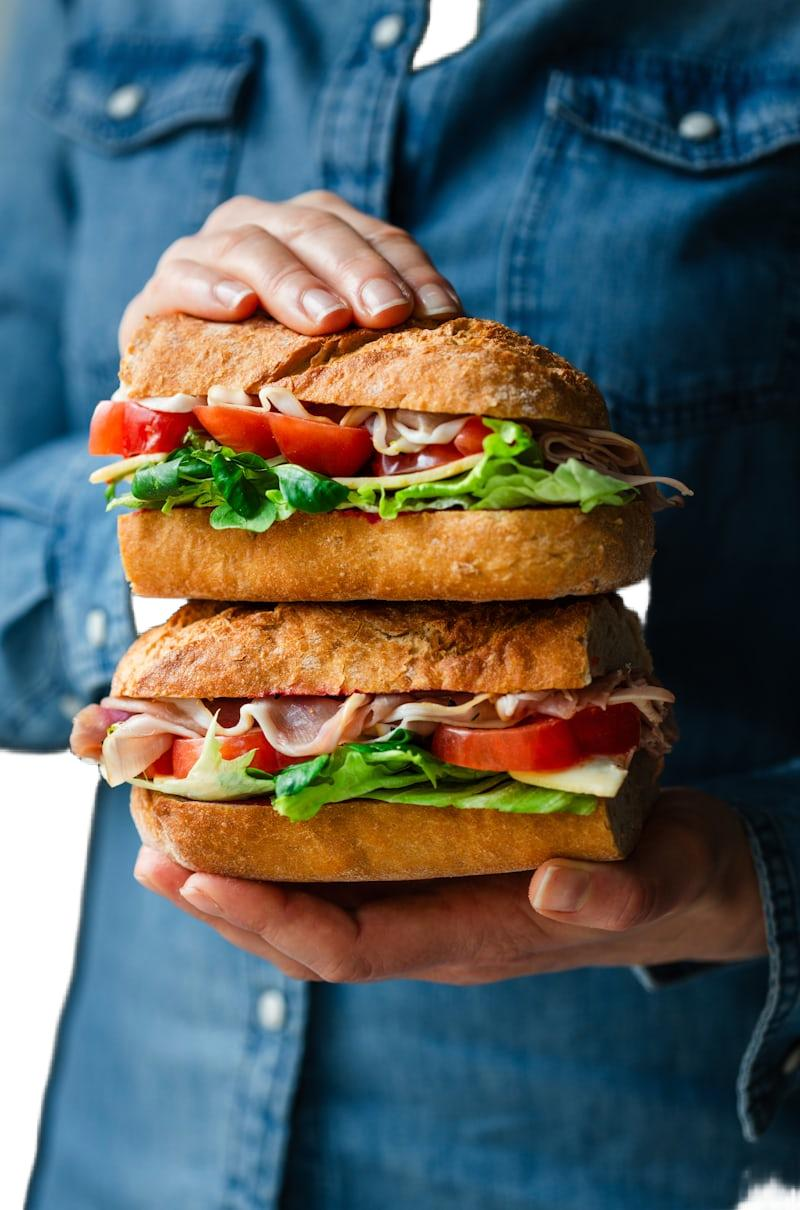


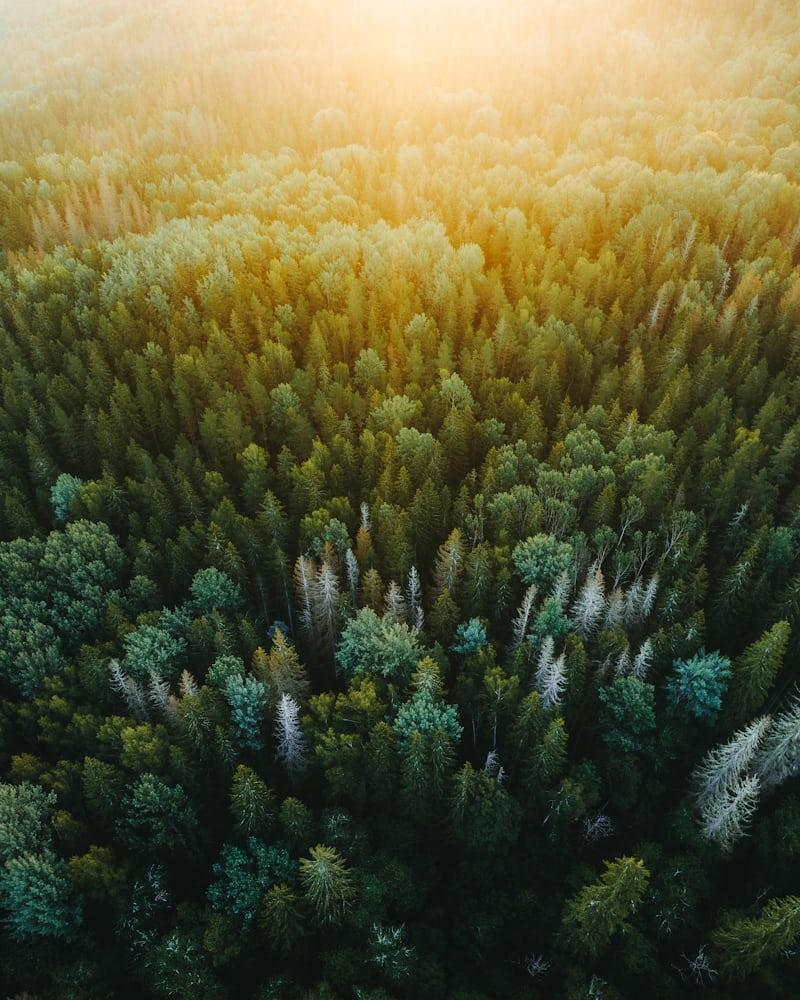
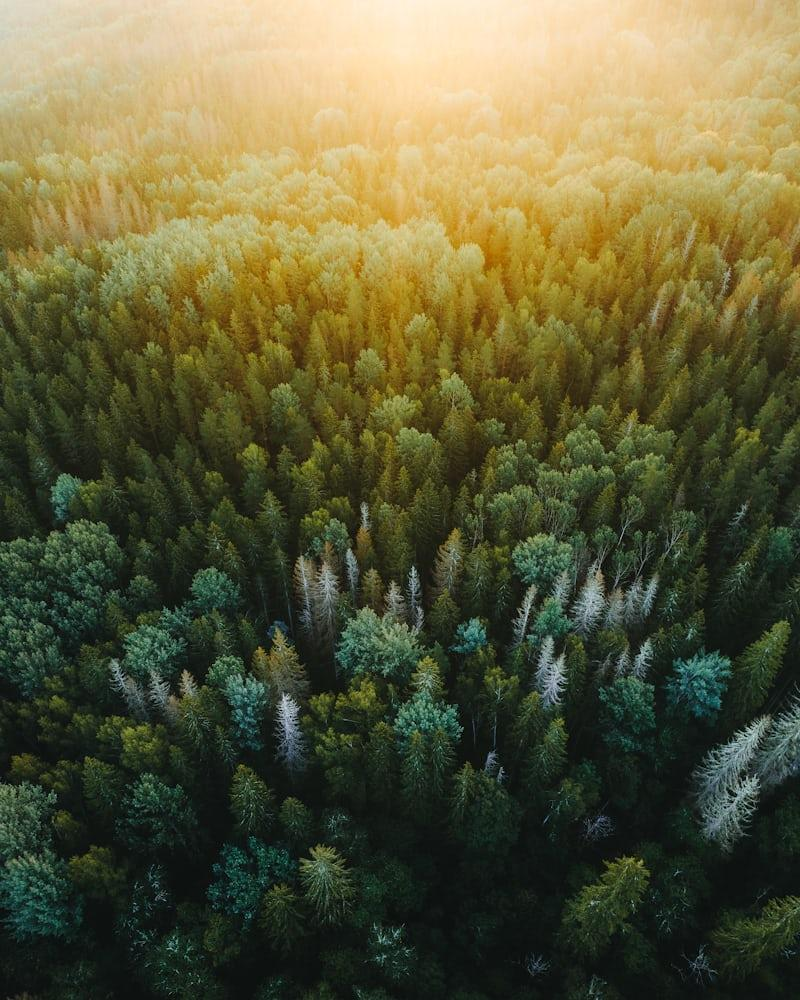


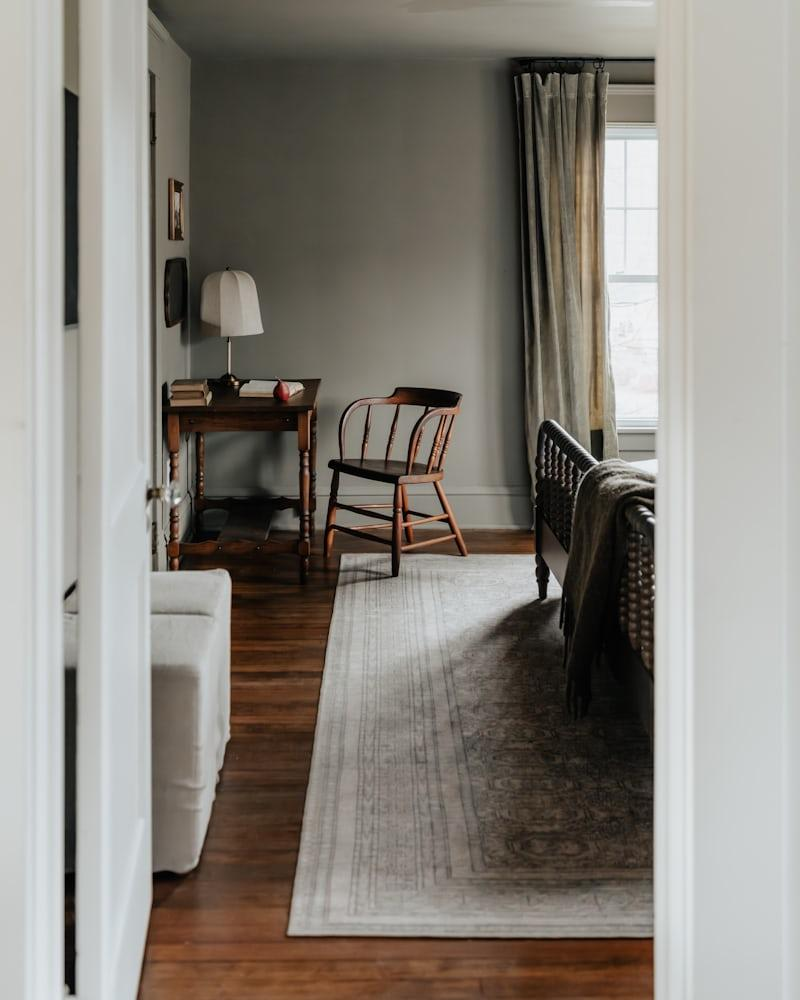
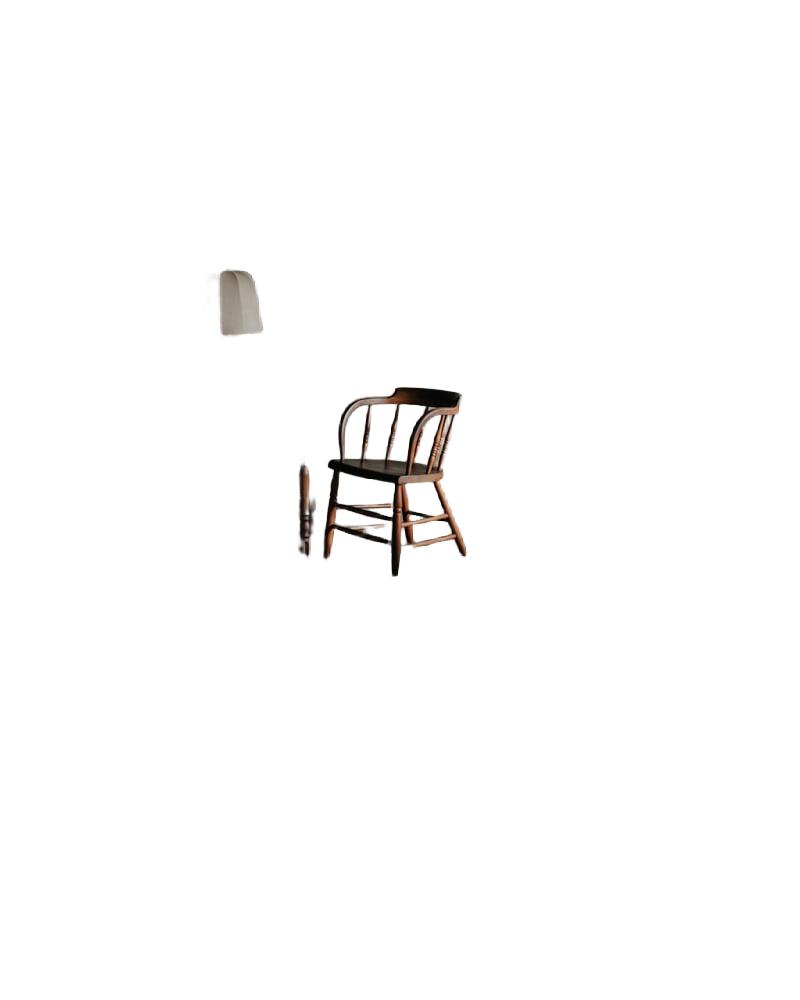

In [17]:
from jupyter_compare_view import compare
from IPython.display import display
from PIL import Image
from io import BytesIO
from IPython.core.display import HTML

target_width = 800

def prepare_img_url(url):
    return f"{url}?q=60&w={target_width}&auto=format&fit=crop"

def fetch_img(url):
    """Fetches an image from a URL and returns a PIL Image object."""
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses (4xx and 5xx)
        return Image.open(BytesIO(response.content)).convert("RGBA")  # Ensure RGBA mode
    except requests.RequestException as e:
        print(f"Error fetching image from {url}: {e}")
        return None

def convert_to_rgb(image):
    if image.mode == "RGBA":
        rgb_image = Image.new("RGB", image.size, (255, 255, 255))  # Create a new RGB image with a white background
        rgb_image.paste(image, mask=image.split()[3])  # Apply transparency mask
        return rgb_image
    return image  # If already RGB, return as is


def remove_background(image_url):
    """Sends an image URL to the Bria background removal API and returns the processed image."""
    try:
        headers = {"api_token": bria_api_token}
        data = {"image_url": image_url}
        
        response = requests.post(bria_api_url, headers=headers, data=data)
        response.raise_for_status()

        # Extract the result URL from the response
        result_data = response.json()
        result_url = result_data.get("result_url")

        if not result_url:
            print("Error: No result URL returned from API.")
            return None

        return fetch_img(result_url)
    
    except requests.RequestException as e:
        print(f"Error during background removal: {e}")
        return None

def load_image(_url):
    url = prepare_img_url(_url)
    before = fetch_img(url)
    after = remove_background(url)
    
    before = convert_to_rgb(before)
    after = convert_to_rgb(after)

    return (before,after)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(load_image, image_urls))

    # Display results
    for result in results:
        if result is None:
            continue

        before, after = result
        compare_widget = compare(before, after, start_mode="horizontal", start_slider_pos=0.5, add_controls=False)
        bordered_widget = f"""
            <div style="border: 1px solid black; padding: 10px; display: inline-block;">
                {compare_widget._repr_html_()}
            </div>
        """
            
            # Display the bordered widget
        display(HTML(bordered_widget))